In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d as montage
from skimage.io import imread
import os
from glob import glob
base_dir = '../data'

In [2]:
all_path_df = pd.DataFrame(dict(path = 
                                glob(os.path.join(base_dir,
                                                  '*', '*', '*', 'image.png'))))
all_path_df['patient_id'] = all_path_df['path'].map(lambda x: x.split('/')[-2])
all_path_df['train_group'] = all_path_df['path'].map(lambda x: x.split('/')[-4])
all_path_df['mask_path'] = all_path_df['path'].map(lambda x: x.replace('image.', 'mask.'))
all_path_df.sample(5)

,path,patient_id,train_group,mask_path
97,../data/train/06a3dcb447c2c47f6736871a4cb791f7...,25559309_20180206,train,../data/train/06a3dcb447c2c47f6736871a4cb791f7...
71,../data/train/398b7de7e44ebd49f28833ff6540e327...,25702027_20180315,train,../data/train/398b7de7e44ebd49f28833ff6540e327...
19,../data/train/928ddaf06d8b94537bcef3f9097d783d...,25696616_20180306,train,../data/train/928ddaf06d8b94537bcef3f9097d783d...
80,../data/train/e00e9619b7d7e84ebf2b044ff2832b17...,25687676_20180313,train,../data/train/e00e9619b7d7e84ebf2b044ff2832b17...
61,../data/train/632993537ded21250fcde5d54b9e8db2...,25541826_20180206,train,../data/train/632993537ded21250fcde5d54b9e8db2...


(192, 224, 4) 0 255 91.96524483816964
(192, 224, 4) 0 255


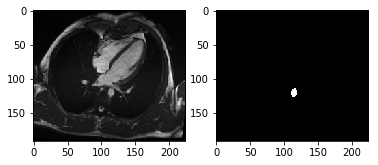

In [3]:
t_img = imread(all_path_df['path'].values[0])
t_mask = imread(all_path_df['mask_path'].values[0])
print(t_img.shape, t_img.min(), t_img.max(), t_img.mean())
print(t_mask.shape, t_mask.min(), t_mask.max())
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(t_img)
ax2.imshow(t_mask)

In [4]:
all_path_df['mask_image'] = all_path_df['mask_path'].map(lambda x: imread(x)[:, :, 0])
all_path_df['image'] = all_path_df['path'].map(lambda x: imread(x)[:, :, 0])

In [5]:
def pad_nd_image(in_img,  # type: np.ndarray
                 out_shape,  # type: List[Optional[int]]
                 mode='reflect',
                 **kwargs):
    # type: (...) -> np.ndarray
    """
    Pads an array to a specific size
    :param in_img:
    :param out_shape: the desired outputs shape
    :param mode: the mode to use in numpy.pad
    :param kwargs: arguments for numpy.pad
    :return:
    >>> pprint(pad_nd_image(np.eye(3), [7,7]))
    [[ 1.  0.  0.  0.  1.  0.  0.]
     [ 0.  1.  0.  1.  0.  1.  0.]
     [ 0.  0.  1.  0.  0.  0.  1.]
     [ 0.  1.  0.  1.  0.  1.  0.]
     [ 1.  0.  0.  0.  1.  0.  0.]
     [ 0.  1.  0.  1.  0.  1.  0.]
     [ 0.  0.  1.  0.  0.  0.  1.]]
    >>> pprint(pad_nd_image(np.eye(3), [2,2])) # should return the same
    [[ 1.  0.  0.]
     [ 0.  1.  0.]
     [ 0.  0.  1.]]
    >>> t_mat = np.ones((2, 27, 29, 3))
    >>> o_img = pad_nd_image(t_mat, [None, 32, 32, None], mode = 'constant', constant_values=0)
    >>> o_img.shape
    (2, 32, 32, 3)
    >>> pprint(o_img.mean())
    0.7646484375
    >>> pprint(o_img[0,3,:,0])
    [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
      1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.]
    """
    pad_dims = []
    for c_shape, d_shape in zip(in_img.shape, out_shape):
        pad_before, pad_after = 0, 0
        if d_shape is not None:
            if c_shape < d_shape:
                dim_diff = d_shape - c_shape
                pad_before = dim_diff // 2
                pad_after = dim_diff - pad_before
        pad_dims += [(pad_before, pad_after)]
    return np.pad(in_img, pad_dims, mode=mode, **kwargs)

def force_array_dim(in_img,  # type: np.ndarray
                    out_shape,  # type: List[Optional[int]]
                    pad_mode='reflect',
                    crop_mode='center',
                    **pad_args):
    # type: (...) -> np.ndarray
    """
    force the dimensions of an array by using cropping and padding
    :param in_img:
    :param out_shape:
    :param pad_mode:
    :param crop_mode: center or random (default center since it is safer)
    :param pad_args:
    :return:
    >>> np.random.seed(2018)
    >>> pprint(force_array_dim(np.eye(3), [7,7], crop_mode = 'random'))
    [[ 1.  0.  0.  0.  1.  0.  0.]
     [ 0.  1.  0.  1.  0.  1.  0.]
     [ 0.  0.  1.  0.  0.  0.  1.]
     [ 0.  1.  0.  1.  0.  1.  0.]
     [ 1.  0.  0.  0.  1.  0.  0.]
     [ 0.  1.  0.  1.  0.  1.  0.]
     [ 0.  0.  1.  0.  0.  0.  1.]]
    >>> pprint(force_array_dim(np.eye(3), [2,2], crop_mode = 'center'))
    [[ 1.  0.]
     [ 0.  1.]]
    >>> pprint(force_array_dim(np.eye(3), [2,2], crop_mode = 'random'))
    [[ 1.  0.]
     [ 0.  1.]]
    >>> pprint(force_array_dim(np.eye(3), [2,2], crop_mode = 'random'))
    [[ 0.  0.]
     [ 1.  0.]]
    >>> get_error(force_array_dim, in_img = np.eye(3), out_shape = [2,2], crop_mode = 'junk')
    'Crop mode must be random or center: junk'
    >>> t_mat = np.ones((1, 7, 9, 3))
    >>> o_img = force_array_dim(t_mat, [None, 12, 12, None], pad_mode = 'constant', constant_values=0)
    >>> o_img.shape
    (1, 12, 12, 3)
    >>> pprint(o_img.mean())
    0.4375
    >>> pprint(o_img[0,3,:,0])
    [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.]
    """
    assert crop_mode in ['random', 'center'], "Crop mode must be random or " \
                                              "center: {}".format(crop_mode)

    pad_image = pad_nd_image(in_img, out_shape, mode=pad_mode, **pad_args)
    crop_dims = []
    for c_shape, d_shape in zip(pad_image.shape, out_shape):
        cur_slice = slice(0, c_shape)  # default
        if d_shape is not None:
            assert d_shape <= c_shape, \
                "Padding command failed: {}>={} - {},{}".format(d_shape,
                                                                c_shape,
                                                                pad_image.shape,
                                                                out_shape
                                                                )
            if d_shape < c_shape:
                if crop_mode == 'random':
                    start_idx = np.random.choice(
                        range(0, c_shape - d_shape + 1))
                    cur_slice = slice(start_idx, start_idx + d_shape)
                else:
                    start_idx = (c_shape - d_shape) // 2
                    cur_slice = slice(start_idx, start_idx + d_shape)
        crop_dims += [cur_slice]
    return pad_image.__getitem__(crop_dims)

In [6]:
all_path_df['mask_image'] = all_path_df['mask_image'].map(lambda x: force_array_dim(x, (224, 224)))
all_path_df['image'] = all_path_df['image'].map(lambda x: force_array_dim(x, (224, 224)))

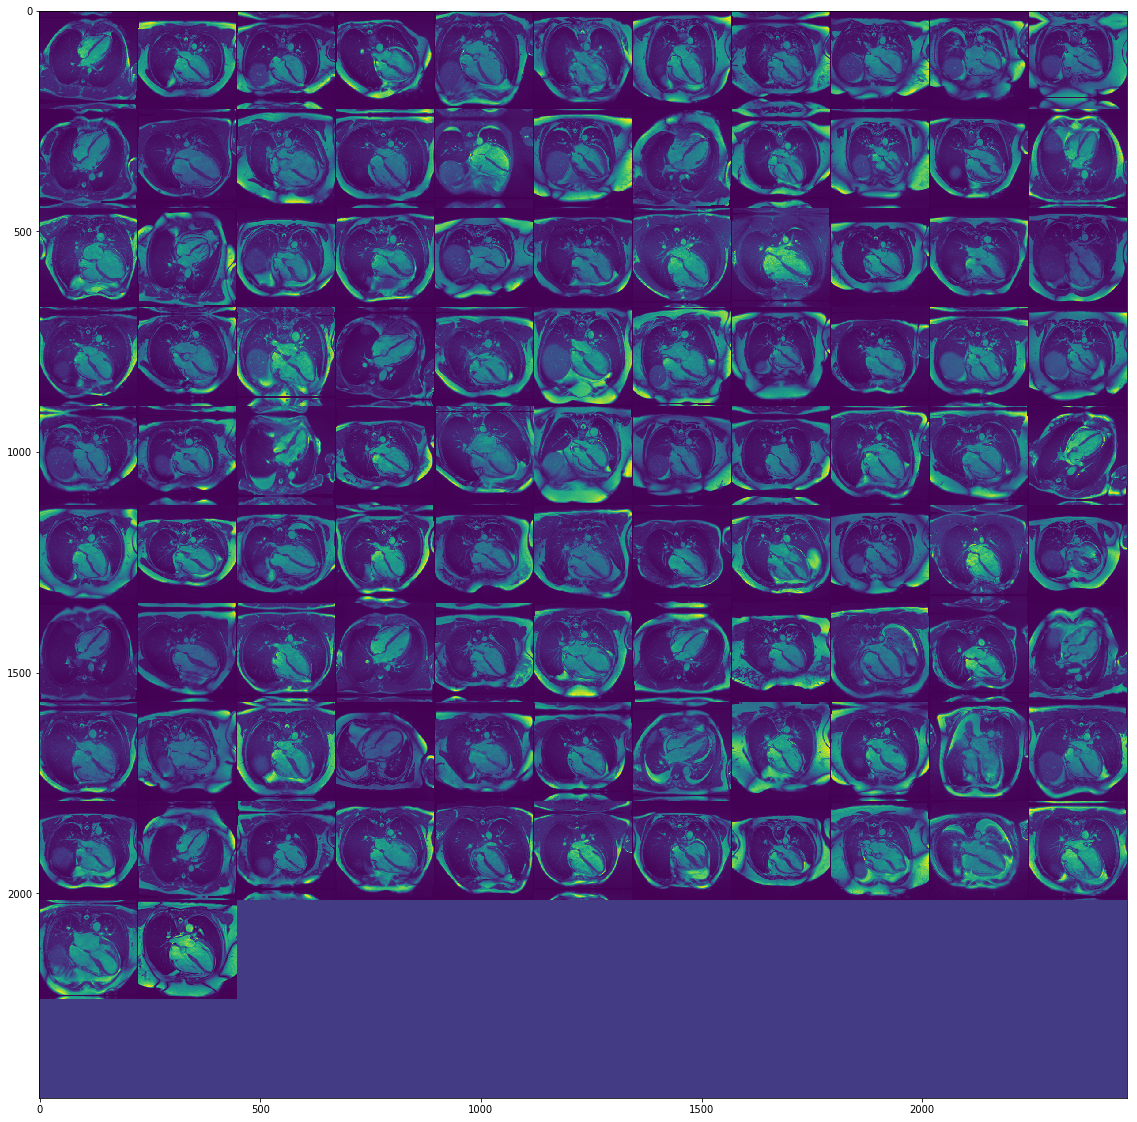

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(np.stack(all_path_df['image'], 0)))

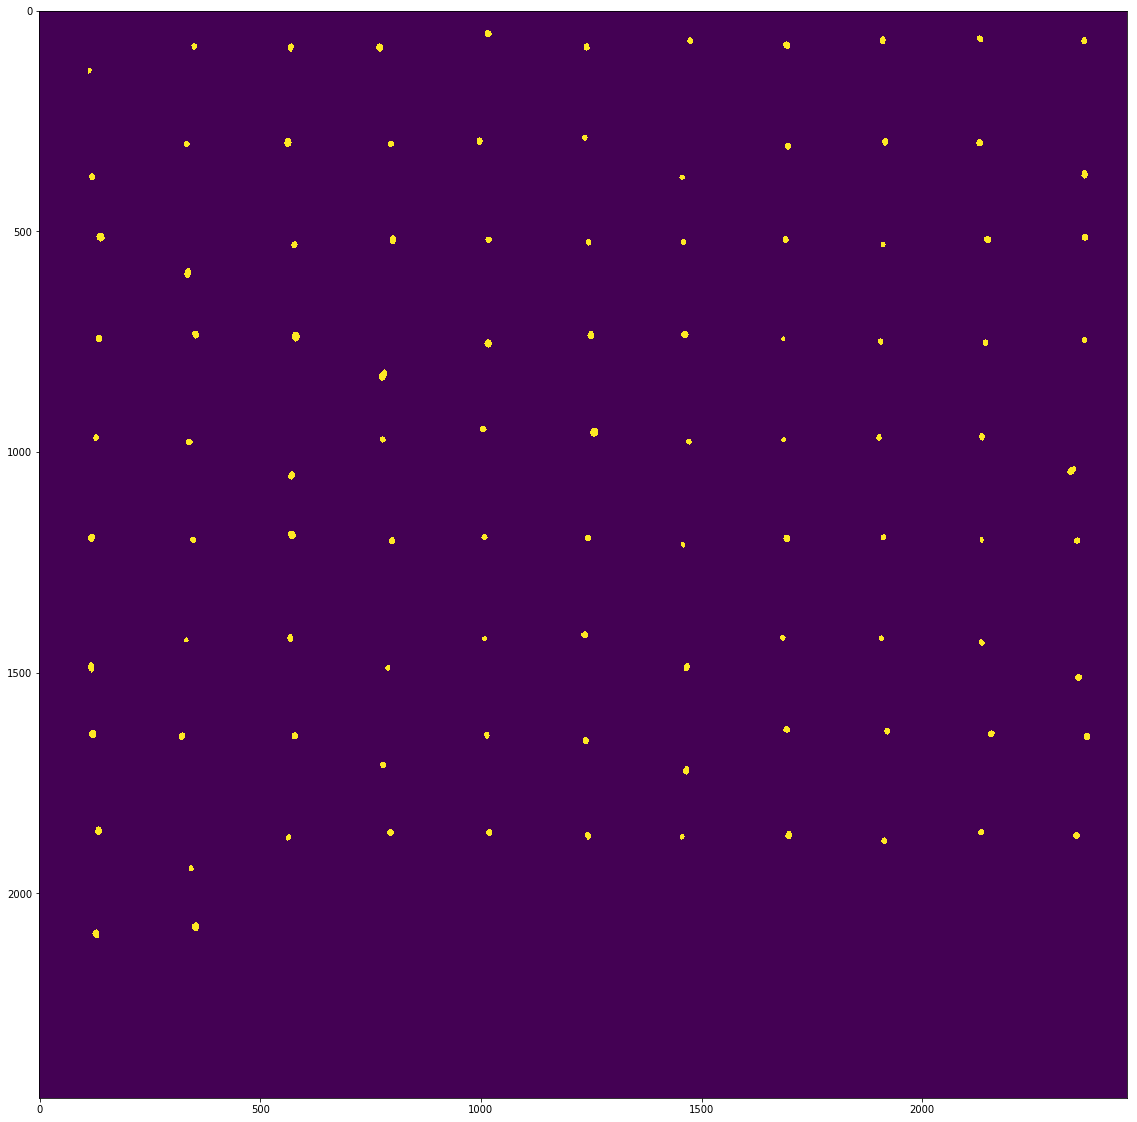

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(np.stack(all_path_df['mask_image'], 0)))

In [9]:
train_df = all_path_df.query('train_group=="train"')
test_df = all_path_df.query('train_group=="test"')
def df_to_block(in_df):
    return np.expand_dims(np.stack(in_df['image'], 0)/255.0, -1), np.expand_dims(np.stack(in_df['mask_image'], 0), -1)/255.0
train_X = df_to_block(train_df)
test_X = df_to_block(test_df)
print(train_X[0].shape,test_X[0].shape)

(93, 224, 224, 1) (8, 224, 224, 1)


In [10]:
from keras.layers import Input, Activation, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, BatchNormalization, Cropping2D, ZeroPadding2D, SpatialDropout2D
from keras.layers import Conv2DTranspose, Dropout, GaussianNoise
from keras.models import Model
from keras import backend as K
def up_scale(in_layer):
    filt_count = in_layer._keras_shape[-1]
    return Conv2DTranspose(filt_count//2+2, kernel_size = (3,3), strides = (2,2), padding = 'same')(in_layer)
def up_scale(in_layer):
    return UpSampling2D(size=(2,2))(in_layer)
input_layer = Input(shape=(None, None, 1))
sp_layer = GaussianNoise(0.05)(input_layer)
bn_layer = BatchNormalization()(sp_layer)
c1 = Conv2D(filters=8, kernel_size=(5,5), activation='relu', padding='same')(bn_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c4)
c5 = Conv2D(filters=64, kernel_size=(1,1), activation='linear', padding='same')(l)
c5 = BatchNormalization()(c5)
c5 = Activation('relu')(c5)
l = concatenate([up_scale(c5), c4], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='linear', padding='same')(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Dropout(0.2)(concatenate([up_scale(l), c3], axis=-1))
l = Conv2D(filters=32, kernel_size=(2,2), activation='linear', padding='same')(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Dropout(0.2)(concatenate([up_scale(l), c2], axis=-1))
l = Conv2D(filters=24, kernel_size=(2,2), activation='linear', padding='same')(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Dropout(0.2)(concatenate([up_scale(l), c1, bn_layer], axis=-1))
l = Conv2D(filters=32, kernel_size=(2,2), activation='linear', padding='same')(l)
l = BatchNormalization()(l)
l = Activation('relu')(l)
l = Conv2D(filters=16, kernel_size=(1,1), activation='relu')(l)
l = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
l = Cropping2D((8,8))(l)
output_layer = ZeroPadding2D((8,8))(l)

seg_model = Model(input_layer, output_layer)
seg_model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, None, None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 4           gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 208         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [11]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-3, decay = 1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/joshy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [21]:
loss_history = [seg_model.fit(train_X[0], train_X[1], 
                          batch_size = 5,
                          shuffle = True,
                          epochs = 50, 
                          validation_data = test_X,
                          callbacks = callbacks_list)]

Train on 93 samples, validate on 8 samples
Epoch 1/50
93/93 [==============================] - 0s 5ms/step - loss: -0.8432 - dice_coef: 0.8432 - binary_accuracy: 0.9989 - true_positive_rate: 0.8410 - val_loss: -0.6816 - val_dice_coef: 0.6816 - val_binary_accuracy: 0.9988 - val_true_positive_rate: 0.7105

Epoch 00001: val_dice_coef improved from -inf to 0.68163, saving model to seg_model_weights.best.hdf5
Epoch 2/50
93/93 [==============================] - 0s 4ms/step - loss: -0.8477 - dice_coef: 0.8477 - binary_accuracy: 0.9989 - true_positive_rate: 0.8523 - val_loss: -0.6819 - val_dice_coef: 0.6819 - val_binary_accuracy: 0.9988 - val_true_positive_rate: 0.7105

Epoch 00002: val_dice_coef improved from 0.68163 to 0.68187, saving model to seg_model_weights.best.hdf5
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: -0.8451 - dice_coef: 0.8451 - binary_accuracy: 0.9989 - true_positive_rate: 0.8520 - val_loss: -0.6819 - val_dice_coef: 0.6819 - val_binary_accuracy: 0.

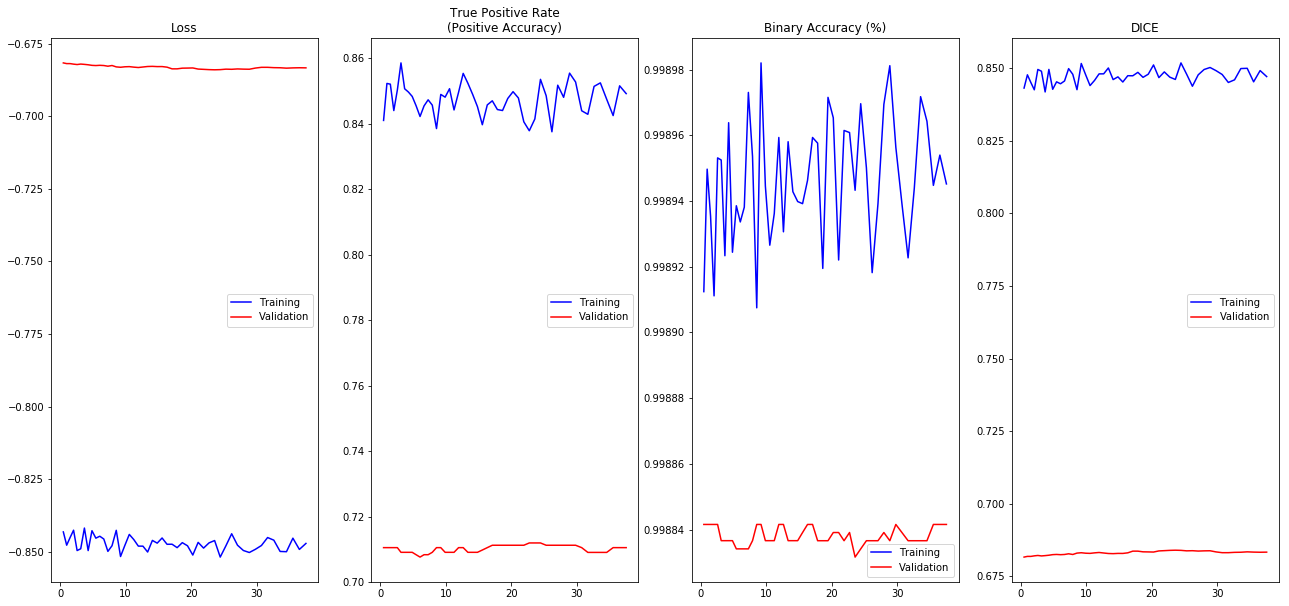

In [22]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')
show_loss(loss_history)

(224, 224, 1) (224, 224, 1)
0.0 1.0
0.0 1.0
(224, 224, 1) (224, 224, 1)
0.0 1.0
0.0 1.0
(224, 224, 1) (224, 224, 1)
0.0 1.0
0.0 1.0
(224, 224, 1) (224, 224, 1)
0.0 1.0
0.0 1.0


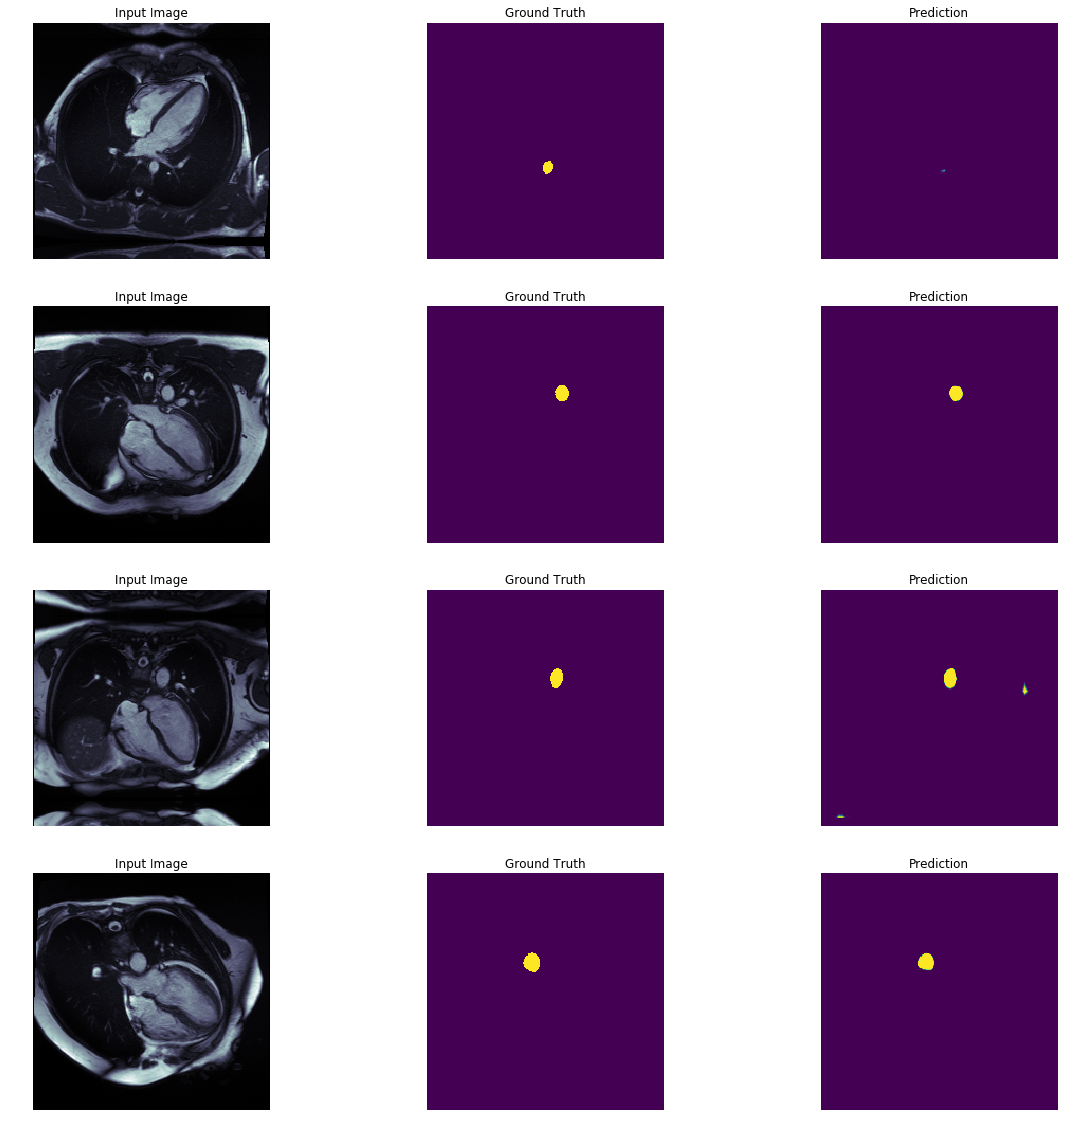

In [23]:
fig, m_axs = plt.subplots(4,3, figsize = (20, 20))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), ix, iy in zip(m_axs, test_X[0], test_X[1]):
    print(ix.shape, iy.shape)
    print(ix.min(), ix.max())
    print(iy.min(), iy.max())
    
    p_image = seg_model.predict(np.expand_dims(ix, 0))
    ax1.imshow(ix[:,:,0], cmap = 'bone')
    ax1.set_title('Input Image')
    ax2.imshow(iy[:,:,0], vmin = 0, vmax = 1, )
    ax2.set_title('Ground Truth')
    ax3.imshow(p_image[0,:,:,0], vmin = 0, vmax = 1)
    ax3.set_title('Prediction')

# Add Augmentation
Here we add basic augmentation to try and improve the segmentation, but we won't get too optimistic yet

In [25]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 30, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.1,
                  zoom_range = [0.5, 1.5],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
image_gen = ImageDataGenerator(**dg_args)
def train_gen():
    # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
    g_x = image_gen.flow(train_X[0], batch_size = 16, seed = 2017)
    g_y = image_gen.flow(train_X[1], batch_size = 16, seed = 2017)
    for i_x, i_y in zip(g_x, g_y):
        yield i_x, i_y
cur_gen = train_gen()

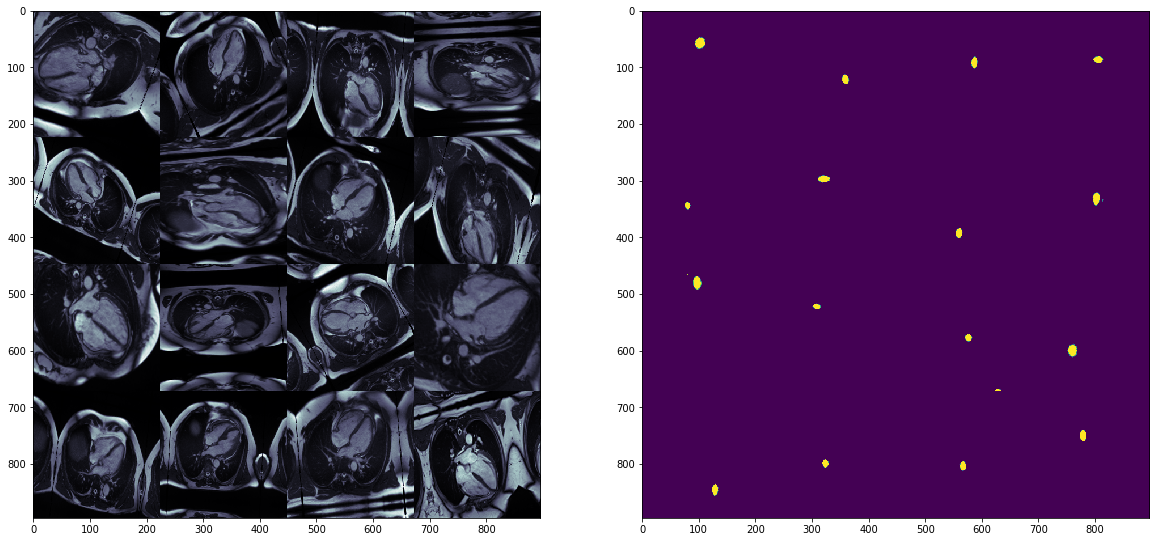

In [26]:
t_x, t_y = next(cur_gen)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(t_x[:, :, :, 0]), cmap = 'bone')
ax2.imshow(montage(t_y[:, :, :, 0]))

In [27]:
loss_history += [seg_model.fit_generator(cur_gen, 
                                         steps_per_epoch=100, 
                                         epochs = 20, 
                                         validation_data = test_X,
                                         callbacks = callbacks_list)]

Epoch 1/20
100/100 [==============================] - 6s 62ms/step - loss: -0.2914 - dice_coef: 0.2914 - binary_accuracy: 0.9951 - true_positive_rate: 0.2327 - val_loss: -0.7085 - val_dice_coef: 0.7085 - val_binary_accuracy: 0.9987 - val_true_positive_rate: 0.7507

Epoch 00001: val_dice_coef improved from 0.68400 to 0.70854, saving model to seg_model_weights.best.hdf5
Epoch 2/20
100/100 [==============================] - 6s 59ms/step - loss: -0.3292 - dice_coef: 0.3292 - binary_accuracy: 0.9952 - true_positive_rate: 0.2807 - val_loss: -0.7354 - val_dice_coef: 0.7354 - val_binary_accuracy: 0.9987 - val_true_positive_rate: 0.7838

Epoch 00002: val_dice_coef improved from 0.70854 to 0.73536, saving model to seg_model_weights.best.hdf5
Epoch 3/20
100/100 [==============================] - 6s 59ms/step - loss: -0.3425 - dice_coef: 0.3425 - binary_accuracy: 0.9948 - true_positive_rate: 0.3008 - val_loss: -0.7520 - val_dice_coef: 0.7520 - val_binary_accuracy: 0.9987 - val_true_positive_rate: 

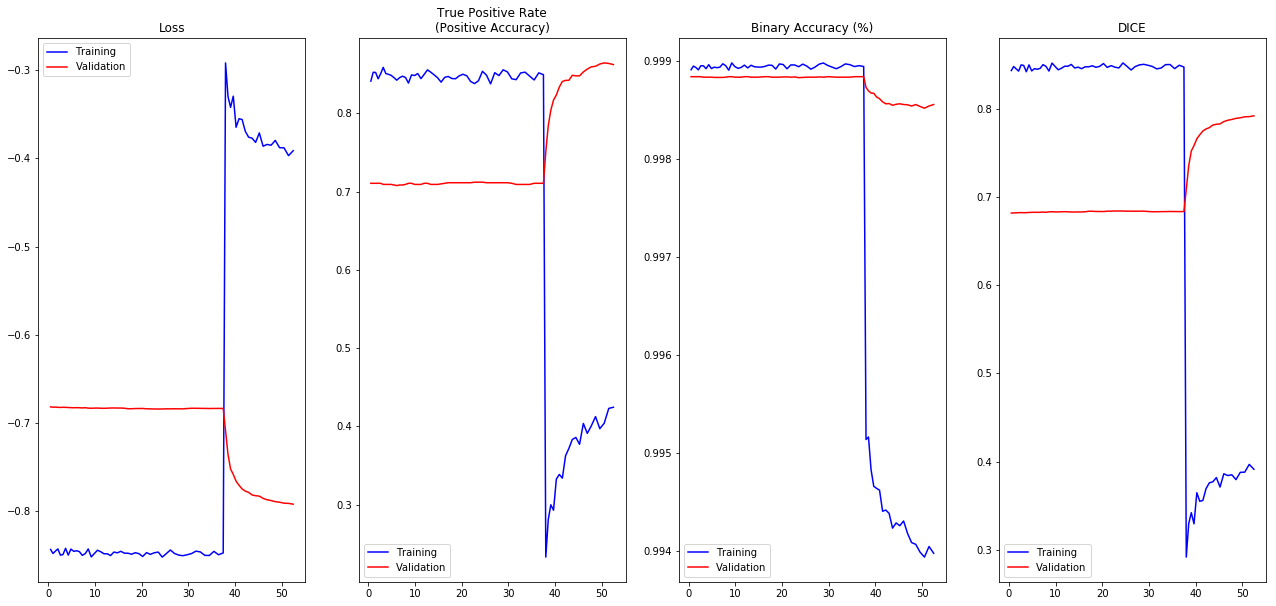

In [28]:
show_loss(loss_history)

In [29]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

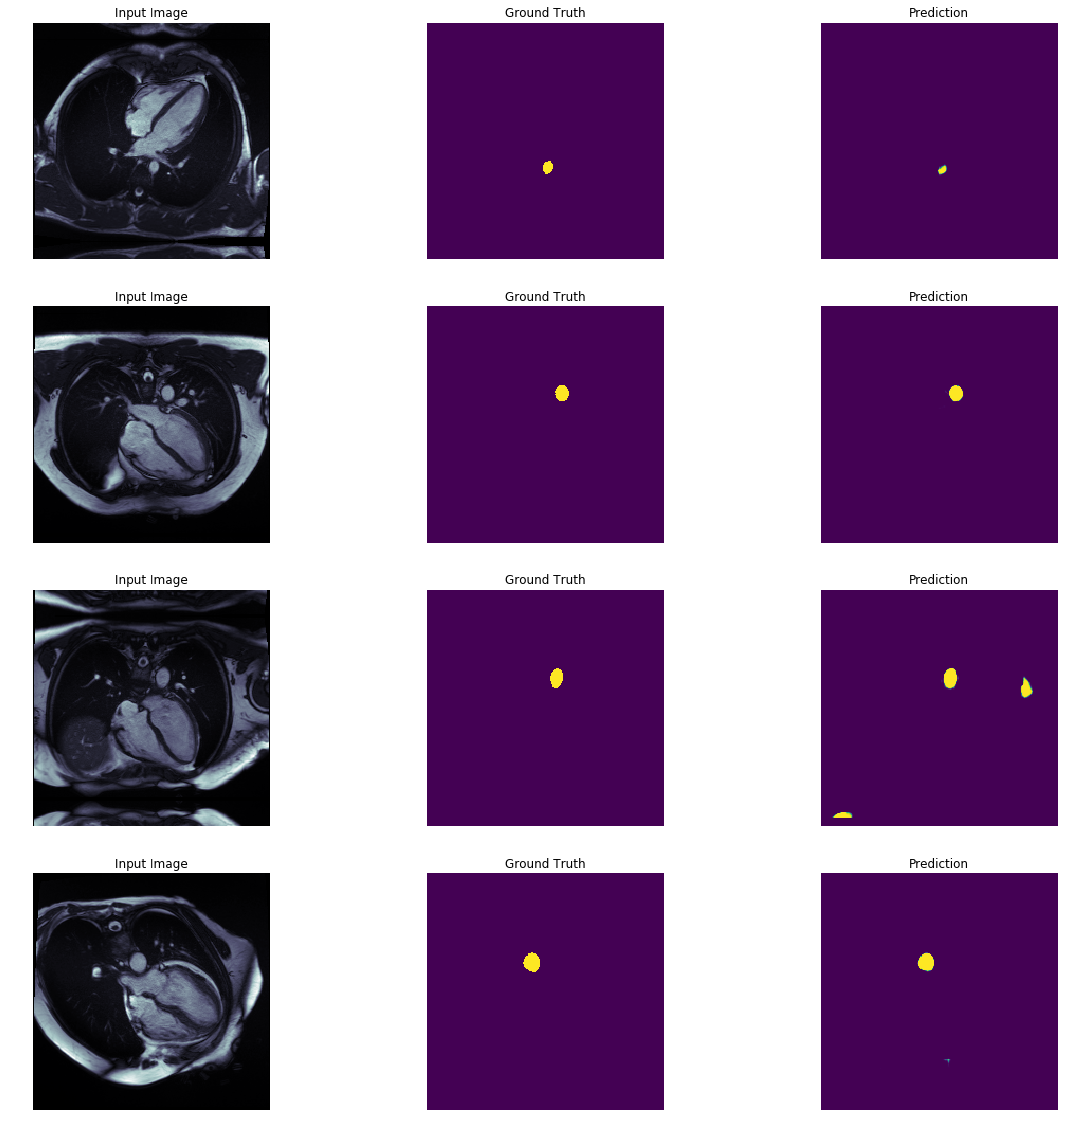

In [30]:
fig, m_axs = plt.subplots(4,3, figsize = (20, 20))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), ix, iy in zip(m_axs, test_X[0], test_X[1]):
    p_image = seg_model.predict(np.expand_dims(ix, 0))
    ax1.imshow(ix[:,:,0], cmap = 'bone')
    ax1.set_title('Input Image')
    ax2.imshow(iy[:,:,0], vmin = 0, vmax = 1, )
    ax2.set_title('Ground Truth')
    ax3.imshow(p_image[0,:,:,0], vmin = 0, vmax = 1)
    ax3.set_title('Prediction')